# LLMeter with Amazon SageMaker JumpStart

This notebook demonstrates how you can use LLMeter to measure latency and performance-under-load for LLMs hosted on [Amazon SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html).

You will need some text to use such as Mary Shelley's Frankenstein which can be found online.

⚠️ WARNING: Using SageMaker can incur significant costs. Do not try this unless you are comfortable managing the cost implications.


# Understanding LLM Performance Metrics

TTFT (Time to First Token) and TTLT (Time to Last Token) are considered basic metrics for LLM performance evaluation.


### TTFT (Time to First Token)

User Experience Metric: Measures perceived responsiveness
Technical Indicator: Shows model initialization and processing efficiency
Business Critical: Impacts user engagement and satisfaction
Target Range: Usually expected in milliseconds to low seconds
Our test showed average TTFT of ~0.77 seconds, which is reasonable
### TTLT (Time to Last Token)

Completion Metric: Shows total response generation time
System Performance: Indicates overall processing capability
Resource Usage: Reflects computational efficiency
Target Range: Varies by use case and response length
Our test showed average TTLT of ~18 seconds
Why These are Basic but Essential

Easy to Measure

Clear start and end points
Consistently measurable across platforms
Directly observable metrics
Universal Applicability

Relevant across all LLM applications
Comparable across different models
Independent of model architecture
Direct Business Impact

TTFT → User satisfaction
TTLT → System throughput
Both → Cost implications

## Practical Applications

When analyzing these metrics, consider:

1. **Performance Optimization:**
   - High TTFT might indicate need for model optimization or infrastructure improvements
   - Wide TTLT distribution might suggest inconsistent performance

2. **User Experience:**
   - TTFT directly impacts perceived responsiveness
   - TTLT affects overall interaction flow

3. **Capacity Planning:**
   - Token distributions help in resource allocation
   - Response time patterns inform scaling decisions

4. **Cost Analysis:**
   - Token counts directly relate to API costs
   - Performance metrics help optimize cost-performance trade-offs

## Red Flags to Watch For:

- Bimodal distributions (suggesting inconsistent behavior)
- Long tails (indicating occasional very slow responses)
- Unexpectedly wide variations in any metric
- Clustering at maximum token limits

## Best Practices for Analysis:

1. Always look at multiple metrics together
2. Consider your specific use case requirements
3. Compare against baseline measurements
4. Monitor trends over time
5. Set appropriate alerting thresholds

This understanding helps in:
- Setting realistic performance expectations
- Identifying optimization opportunities
- Making informed deployment decisions
- Ensuring good user experience

Would you like me to elaborate on any of these aspects or provide more specific examples from our data?

## Analyzing LLM Performance with Frankenstein Text Sample
The text sample from Frankenstein is good for testing because it contains several characteristics that can help evaluate LLM performance:

Varied Length Components:

Contains dialogue Descriptive passages Multiple paragraphs Different sentence lengths Complex Language Elements:

Archaic language ("thou art", "wreaked") Emotional content Metaphorical language Complex sentence structures Contextual Richness:

Character interactions Emotional states Physical descriptions Environmental details What to Look For in the Metrics

Time to First Token (TTFT)

With this text, TTFT will show how quickly the model begins processing:

Complex vocabulary might impact initial response time Historical language might require additional processing The emotional content might influence response initiation Time to Last Token (TTLT)

TTLT becomes particularly interesting because:

The text has natural breaking points (dialogue, descriptions) Varying sentence structures might affect generation speed The complexity of language might impact overall completion time Token Distribution

This text is particularly useful for token analysis because:

It contains both simple and complex vocabulary Includes archaic terms that might require special tokenization Has natural variation in sentence and paragraph lengths

## Setting Up

First, ensure your environment is set up with the required libraries to run the example. In addition to `llmeter` itself, we'll need:

- `sagemaker` - for looking up SageMaker Jumpstart configurations and working with model deployments
- `transformers` - for measuring and slicing text by token counts

In [ ]:
%pip install "llmeter[plotting]<1" "sagemaker>=2.224,<3" "transformers>=4.40,<5"

In [ ]:
# Python Built-Ins:
import json

# External Dependencies:
from llmeter.endpoints import SageMakerEndpoint, SageMakerStreamEndpoint
from llmeter.runner import Runner
from sagemaker.jumpstart.model import JumpStartModel
from transformers import AutoTokenizer
from upath import UPath  # Combined APIs for accessing cloud or local storage

Next, you'll need a deployed SageMaker endpoint to test against.

If you have on deployed already, fill in the `endpoint_name` below to use it.

Alternatively, this notebook can create one for you: Fill in a valid LLM `model_id` from the SageMaker JumpStart model hub or [this reference table](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html). Examples include:

- `meta-textgeneration-llama-3-1-8b-instruct` (Instruction-tuned Llama 3.1 8B)
- `huggingface-llm-mistral-7b-instruct-v3` (Instruction-tuned Mistral 7B)
- ...and many more!

> ⚠️ **WARNING:** SageMaker Endpoints are billable resources charged by deployed instance-hour until the endpoint is deleted, and Large Language Models typically depend on high-performance accelerated compute.
>
> - Check out the [SageMaker pricing page](https://aws.amazon.com/sagemaker/pricing/) for details on how you'll be charged for deployed endpoints on different instance types
> - The automatic deployment code below will use the default instance type for your chosen model. For more control, consider manually creating your endpoint(s) through the [JumpStart model hub UI](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html) or refer to the detailed docs on [deploying JumpStart models from Python](https://sagemaker.readthedocs.io/en/stable/overview.html#deploy-a-pre-trained-model-directly-to-a-sagemaker-endpoint).
> - Remember to **delete your endpoint(s)** when you're done experimenting - either from the [SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/endpoints) or referring to the *Clean up* section of this notebook.

In [4]:
endpoint_name = "jumpstart-dft-hf-llm-mistral-7b-ins-20250414-004312"  # <-- Replace with an endpoint name or leave as `None` to create a new one
model_id = None  # <-- If creating a new endpoint, replace with a model ID from SageMaker JumpStart
model_version = "*"  # <-- Replace with a specific version or leave `*` to use the latest one
accept_eula = True  # <-- some Jumpstart models requires explicitly accepting a EULA

In [ ]:
if endpoint_name is None:
    if model_id is None:
        raise ValueError("Either model_id or endpoint_name must be provided.")

    # Look up the provided model ID in the JumpStart hub:
    model = JumpStartModel(model_id=model_id, model_version=model_version)
    # Deploy with default settings (i.e. whatever this model's default instance type is):
    predictor = model.deploy(accept_eula=accept_eula, wait=True)
    endpoint_name = predictor.endpoint_name  # type: ignore

else:
    from sagemaker.jumpstart.session_utils import get_model_info_from_endpoint
    from sagemaker.predictor import retrieve_default

    # Connect to the existing endpoint:
    model_id, model_version, _, _, _ = get_model_info_from_endpoint(
        endpoint_name=endpoint_name
    )
    model = JumpStartModel(model_id=model_id, model_version=model_version)
    predictor = retrieve_default(endpoint_name=endpoint_name)

# SageMaker JumpStart models offer example payload(s) to illustrate their request format:
sample_payloads = [k.body for k in (model.retrieve_all_examples() or []) if k.body]
print(f"Got {len(sample_payloads)} sample payloads")
print("Sample payload 1:\n")
print(json.dumps(sample_payloads[0], indent=4))

# Try running the payload through the model to check it's deployed and working:
model_output = predictor.predict(sample_payloads[0])
print("Model output:\n")
print(json.dumps(model_output, indent=4))

Under the hood, LLMs represent text (and other media) in terms of discrete ["tokens"](https://en.wikipedia.org/wiki/Large_language_model#Tokenization) and in general response speed is strongly dependent on how many tokens are ingested and generated.

For our experiments, we'll need a **tokenizer**:

1. To automatically prepare input text payloads of different (approximate) token-lengths to help build up a "latency heatmap"
2. *In some cases*, to estimate the number of input tokens ingested and output tokens generated for each LLM request, since *some* JumpStart models don't provide this information
    - ℹ️ **Note:** Some LLM services (like Amazon Bedrock, and JumpStart models based on the [LMI/DJL container](https://docs.djl.ai/master/docs/serving/serving/docs/lmi/user_guides/lmi_input_output_schema.html#details)) actually include the consumed input & output token counts in each API response, and LLMeter will use this data wherever possible. Otherwise, it'll estimate the counts using your provided tokenizer function.

LLMeter does provide a ["dummy" tokenizer](../llmeter/tokenizers.py) by default which will split text on white-space (i.e. into "words"), but this gives a very rough approximation even in languages like English - and isn't really usable at all in languages (like Chinese, Japanese, Korean, Thai, etc) that don't separate words in this way.

In this example we'll use an open access LLama-3 tokenizer from Huggingface hub, but you can also use others like tiktoken or custom objects - as long as they provide `encode()` and `decode()` methods:

In [6]:
tokenizer = AutoTokenizer.from_pretrained("philschmid/meta-llama-3-tokenizer")

tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

## Basic inference and test runs

To measure the latency and throughput of the endpoint (including the network latency from the client where LLMeter is running to the actual endpoint), we start by creating a [`llmeter.Endpoint`](../llmeter/endpoints/base.py) object specifically for JumpStart real-time deployments.

In [7]:
# Create an LLMeter Endpoint object for your deployed SageMaker endpoint:
sagemaker_endpoint = SageMakerEndpoint(
    endpoint_name,
    model_id=model_id,
    # The output path can be inferred from the example model output generated above:
    # (It may vary between different JumpStart models)
    generated_text_jmespath="[0].generated_text",
)

[04/14/25 01:06:14] INFO     Using AWS region: us-west-2                                            ]8;id=37198;file:///opt/conda/lib/python3.12/site-packages/llmeter/endpoints/sagemaker.py\sagemaker.py]8;;\:]8;id=146304;file:///opt/conda/lib/python3.12/site-packages/llmeter/endpoints/sagemaker.py#43\43]8;;\

We can now verify that LLMeter is correctly capturing the output of the endpoint

In [8]:
response = sagemaker_endpoint.invoke(payload=sample_payloads[0])
print(response)

{
    "response_text": "<s>[INST] what is the recipe of mayonnaise? [/INST]Mayonnaise is a creamy condiment made from oil, egg yolks, acid (often vinegar or lemon juice), and seasonings such as salt and mustard. Here's a basic recipe for homemade mayonnaise:\n\nIngredients:\n- 1 egg yolk\n- 1 tablespoon of mustard (Dijon or yellow)\n- 1 tablespoon of white vinegar or lemon juice\n- 1 cup of oil (canola, vegetable, or light olive oil)\n- Salt to taste\n- Pepper to taste\n\nInstructions:\n1. In a medium-sized bowl, whisk together the egg yolk, mustard, and vinegar or lemon juice.\n2. Slowly drizzle in the oil while continually whisking the mixture. It is essential to add the oil very slowly to prevent the mixture from breaking and becoming oily.\n3. Once half of the oil has been incorporated, you can gradually increase the speed of adding oil.\n4. Season the mayonnaise with salt and pepper to taste.\n5. Store the mayonnaise in the refrigerator for up to a week.\n\nNote: If the may",
    

You should see that:
- `time_to_last_token` (the overall response time) has been captured by LLMeter
- `time_to_first_token` is missing, because we didn't enable response streaming (see next section)
- for *most* models `num_tokens_input` and `num_tokens_output` (and therefore `time_per_output_token` too) will also be null - because the SageMaker endpoint didn't explicitly return input or output token counts.

Of course a single data point give us much confidence about typical endpoint performance.

We can use the [`Runner`](../llmeter/runner.py) class to set up a basic test run and calculate statistics.
- `clients` configures the number of concurrent (thread-based) clients that will send requests to the endpoint.
- `n_requests` is the total number of consecutive requests **each client** should perform (so the endpoint will receive clients * n_requests requests in total).
- `payload`s are the sample request(s) that should be used for the test. If `n_requests=None`, each client will just iterate through this list. Otherwise, the list will be shuffled to generate the required number of requests.
- `tokenizer` can be provided as a fallback to estimate the number of input & output tokens for APIs (like many SageMaker models) that don't explicitly report these counts.
- `output_path` can be a local path or `s3://...` URI, where the test results should be saved.

The `run()` method is an async function, and to execute it in a Jupyter notebook it requires to use the `await` keyword!

In [9]:
endpoint_test = Runner(
    sagemaker_endpoint,
    tokenizer=tokenizer,
    output_path=f"outputs/{sagemaker_endpoint.model_id}",
)
results = await endpoint_test.run(payload=sample_payloads, n_requests=3, clients=3)

[04/14/25 01:06:58] INFO     Starting test                                                            ]8;id=159291;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=11907;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#444\444]8;;\

Total requests:   0%|          | 0/9 [00:00<?, ?it/s]

                    INFO     Starting token counting from queue                                       ]8;id=510864;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=93053;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#229\229]8;;\

                    INFO     Generating 3 connections with 3 invocations each                         ]8;id=242760;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=544438;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#392\392]8;;\

[04/14/25 01:07:20] INFO     Generated 3 connections with 3 invocations each in 21985.87 seconds      ]8;id=499748;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=375441;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#404\404]8;;\

                    INFO     Test completed in 21985.87 seconds.                                      ]8;id=146039;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=295528;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#476\476]8;;\

Once the test is completed, we can check the overall statistics aggregated from all the clients and requests:

In [10]:
print(results)

{
    "total_requests": 9,
    "clients": 3,
    "n_requests": 3,
    "total_test_time": 21.985874049999893,
    "model_id": "huggingface-llm-mistral-7b-instruct-v3",
    "output_path": "outputs/huggingface-llm-mistral-7b-instruct-v3/20250414-0106",
    "endpoint_name": "jumpstart-dft-hf-llm-mistral-7b-ins-20250414-004312",
    "provider": "sagemaker",
    "run_name": "20250414-0106",
    "run_description": null,
    "start_time": "2025-04-14T01:06:58Z",
    "end_time": "2025-04-14T01:07:20Z",
    "failed_requests": 0,
    "failed_requests_rate": 0.0,
    "requests_per_minute": 24.561225028940918,
    "total_input_tokens": 168,
    "total_output_tokens": 1741,
    "average_input_tokens_per_minute": 458.4762005402304,
    "average_output_tokens_per_minute": 4751.23253059846,
    "time_to_last_token-average": 7.063058009111198,
    "time_to_last_token-p50": 8.827763031999893,
    "time_to_last_token-p90": 8.928590311000335,
    "time_to_last_token-p99": 8.930737338400286,
    "num_tokens

We can also drill down to the individual responses if needed, as shown below.

Note that (unlike the single-execution example earlier) the token counts have been filled in with estimates from the provided tokenizer.

In [ ]:
#results.responses

If the `output_path` was set, we can also find this information saved to files in the provided location:

In [12]:
print(f"Contents of {results.output_path}\n----")
for sub in UPath(results.output_path).iterdir():
    print(sub)

Contents of outputs/huggingface-llm-mistral-7b-instruct-v3/20250414-0106
----
outputs/huggingface-llm-mistral-7b-instruct-v3/20250414-0106/payload.jsonl
outputs/huggingface-llm-mistral-7b-instruct-v3/20250414-0106/run_config.json
outputs/huggingface-llm-mistral-7b-instruct-v3/20250414-0106/responses.jsonl
outputs/huggingface-llm-mistral-7b-instruct-v3/20250414-0106/summary.json
outputs/huggingface-llm-mistral-7b-instruct-v3/20250414-0106/stats.json


## Streaming responses and Time-to-First-Token

Many LLM providers support *streaming* APIs which reduce user-perceived latency by sending the response in chunks rather than waiting for the whole generation to finish. In these contexts, the `time_to_first_token` is also a useful metric to understand how long consumers will have to wait before they can start to process the response.

If the selected Jumpstart endpoint supports model streaming, we can instead create an LLMeter `SageMakerStreamEndpoint` to handle this:

In [ ]:
sagemaker_endpoint_stream = SageMakerStreamEndpoint(endpoint_name, model_id=model_id)

To get a streaming output, we'll typically need to modify the payloads to include `"stream": true` - although the exact syntax may vary between different SageMaker JumpStart models:

In [ ]:
payloads_streaming = [{**k, "stream": True} for k in sample_payloads]
#payloads_streaming

As before, we can first test that the `Endpoint` is correctly configured.

In [15]:
response = sagemaker_endpoint_stream.invoke(payload=payloads_streaming[0])
print(response)

{
    "response_text": " Mayonnaise is a creamy sauce made from oil, egg yolks, and an acid such as vinegar or lemon juice. Here's a basic recipe for homemade mayonnaise:\n\nIngredients:\n- 1 egg yolk\n- 1 teaspoon mustard (Dijon or yellow mustard)\n- 1 tablespoon white wine vinegar or lemon juice\n- 1 cup vegetable oil (canola or olive oil)\n- Salt, to taste\n\nInstructions:\n1. In a medium bowl, whisk together the egg yolk, mustard, and vinegar or lemon juice.\n2. Slowly drizzle in the oil while continuously whisking the mixture until it thickens. Start drizzling the oil very slowly at first, and gradually increase the speed as the mayonnaise thickens.\n3. If the mayonnaise becomes too thick, thin it out with a bit more acid or a splash of water.\n4. Season with salt to taste.\n5. Store the mayonnaise in an airtight container in the refrigerator for up to one week.</s>",
    "input_payload": {
        "inputs": "<s>[INST] what is the recipe of mayonnaise? [/INST]",
        "parameter

Once we're satisfied that the `Endpoint` is working as expected and we're now able to capture the `time_to_first_token` metric on the response - we can set up out test runner and `run()` it, as we did for the non-streaming case above.

In [ ]:
endpoint_stream_test = Runner(
    sagemaker_endpoint_stream,
    tokenizer=tokenizer,
    output_path=f"outputs/{sagemaker_endpoint_stream.model_id}",
)
results_stream = await endpoint_stream_test.run(
    payload=payloads_streaming, clients=20, n_requests=5
)

We can view the summary statistics and individual responses as before, but now have a additional statistics to work with:

> ℹ️ **Note:** The `time_to_last_token` may differ between streaming and non-streaming invocations, so it's important to test the invocation method you'll actually be using. Don't choose to test streaming only because it provides additional statistics!

In [17]:
print(results_stream)

{
    "total_requests": 100,
    "clients": 20,
    "n_requests": 5,
    "total_test_time": 47.57442754400017,
    "model_id": "huggingface-llm-mistral-7b-instruct-v3",
    "output_path": "outputs/huggingface-llm-mistral-7b-instruct-v3/20250414-0108",
    "endpoint_name": "jumpstart-dft-hf-llm-mistral-7b-ins-20250414-004312",
    "provider": "sagemaker",
    "run_name": "20250414-0108",
    "run_description": null,
    "start_time": "2025-04-14T01:08:28Z",
    "end_time": "2025-04-14T01:09:15Z",
    "failed_requests": 0,
    "failed_requests_rate": 0.0,
    "requests_per_minute": 126.11817545152337,
    "total_input_tokens": 6020,
    "total_output_tokens": 22681,
    "average_input_tokens_per_minute": 7592.314162181707,
    "average_output_tokens_per_minute": 28604.863374160017,
    "time_to_last_token-average": 8.88662528644998,
    "time_to_last_token-p50": 9.779906545999893,
    "time_to_last_token-p90": 10.599748710899894,
    "time_to_last_token-p99": 11.019443770769513,
    "tim

In [ ]:
# results_stream.responses

Now you've seen the core mechanics of running tests with LLMeter, let's explore some of the higher-level *experiments* that use these low-level runners under the hood.

(Assuming you installed LLMeter with the `plotting` extras, as shown at the start of this notebook), you'll be able to plot the heatmap results visually to explore how the latency varies with input and output token count:

For many models the overall `time_to_last_token` depends more strongly on the number of tokens *generated* by the model (`num_tokens_output`), while the `time_to_first_token` depends more strongly on the *input* length (`num_tokens_input`) if any significant correlation is present.

## Load testing with concurrent request ramp-up

If you're using a large-scale, as-a-service LLM provider like [Amazon Bedrock](https://aws.amazon.com/bedrock/), it's likely that the request volume for your use-case is insignificant compared to what the service handles overall - in which case you should check your [API quotas](https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html) are sufficient for your workload, but there's probably **limited value** in running actual load/volume tests.

However, if you're deploying an LLM on a service like Amazon SageMaker where you **size the underlying infrastructure** (number of compute instances, GPUs, etc) - then of course it will be important to understand how the latency of your model varies depending on the number of concurrent users / requests.

LLMeter's `LoadTest` experiment makes it easy to measure how latency and throughput change as a function of the number of requests.

As shown below, you configure:
- `sequence_of_clients` - the different concurrent request counts you'd like to measure latency & throughput for
- `n_requests` - the number of requests *each client* should send *in each test run* (i.e. the total number of requests received by the endpoint will be this multiplied by the sum of all the sequence_of_clients counts)

> ℹ️ In this example we'll use the same set of sample payloads as the previous sections, but since processing time is request- and response-dependent, you should ideally use payloads that are representative of your actual workload when load testing.

In [ ]:
from llmeter.experiments import LoadTest

load_test = LoadTest(
    endpoint=sagemaker_endpoint_stream,
    payload=payloads_streaming,
    sequence_of_clients=[1, 5, 20, 50, 100, 500],
    min_requests_per_client=5,
    min_requests_per_run=10,
    output_path=f"outputs/{sagemaker_endpoint_stream.model_id}/load_test",
)
load_test_results = await load_test.run()

Detailed results are available for each concurrency level run in the load test:

In [ ]:
print(load_test_results)

...And (again assuming you installed LLMeter with the `plotting` extras, as shown at the start of this notebook), you can plot the output for a visual understanding of how the endpoint responds to the increase in the number of concurrent requests:

In [42]:
def prompt_fn(prompt, **kwargs):
    formatted_prompt = f"Create a story based on the following prompt: {prompt}"
    return SageMakerStreamEndpoint.create_payload(formatted_prompt, **kwargs)

Note the results are graphed here by `requests_per_minute` (throughput), so you might see the lines *turn back on themselves* if you reached a concurrent request/client count at which your endpoint became overwhelmed and processes fewer requests overall.

In [50]:
from llmeter.experiments import LatencyHeatmap
import os
from pathlib import Path

# Create output directory path
base_dir = Path("outputs/heatmap")
run_name = "heatmap_test"  # Add a specific run name
output_dir = base_dir / run_name
output_dir.mkdir(parents=True, exist_ok=True)

# Create the heatmap experiment
latency_heatmap = LatencyHeatmap(
    endpoint=sagemaker_endpoint_stream,
    clients=20,
    requests_per_combination=50,
    output_path=output_dir,
    source_file="MaryShelleyFrankenstein.txt", # replace with your own text if using a different onr
    input_lengths=[50, 500, 1000],
    output_lengths=[128, 512, 1024],
    create_payload_fn=prompt_fn,
    tokenizer=tokenizer,
)

# Run the heatmap experiment with explicit output path
heatmap_results = await latency_heatmap.run(output_path=output_dir)

print(heatmap_results)

[04/14/25 02:14:56] INFO     Starting test                                                            ]8;id=41114;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=107967;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#444\444]8;;\

Total requests:   0%|          | 0/440 [00:00<?, ?it/s]

                    INFO     Starting token counting from queue                                       ]8;id=323165;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=491386;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#229\229]8;;\

                    INFO     Generating 20 connections with 22 invocations each                       ]8;id=449302;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=266745;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#392\392]8;;\

[04/14/25 02:15:47] WARNING  Connection pool is full, discarding connection:                  ]8;id=894287;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=736104;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=788988;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=709803;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=268938;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=217298;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             9                                                                                     

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=226381;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=653698;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             9                                                                                     

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=396395;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=379209;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             9                                                                                     

[04/14/25 02:21:33] WARNING  Connection pool is full, discarding connection:                  ]8;id=625203;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=511601;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

[04/14/25 02:21:34] WARNING  Connection pool is full, discarding connection:                  ]8;id=712957;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=443798;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=961593;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=930906;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=665913;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=702617;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

[04/14/25 02:21:35] WARNING  Connection pool is full, discarding connection:                  ]8;id=976552;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=229400;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=942678;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=333719;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=155573;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=916962;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=883250;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=397415;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=846258;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=493283;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    WARNING  Connection pool is full, discarding connection:                  ]8;id=911102;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=959986;file:///opt/conda/lib/python3.12/site-packages/urllib3/connectionpool.py#327\327]8;;\
                             runtime.sagemaker.us-west-2.amazonaws.com. Connection pool size:                      
                             10                                                                                    

                    INFO     Generated 20 connections with 22 invocations each in 398732.73 seconds   ]8;id=42605;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=315042;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#404\404]8;;\

                    INFO     Test completed in 398732.73 seconds.                                     ]8;id=346653;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py\runner.py]8;;\:]8;id=903771;file:///opt/conda/lib/python3.12/site-packages/llmeter/runner.py#476\476]8;;\

{
    "total_requests": 440,
    "clients": 20,
    "n_requests": 22,
    "total_test_time": 398.7327325749993,
    "model_id": "huggingface-llm-mistral-7b-instruct-v3",
    "output_path": "outputs/heatmap/heatmap_test",
    "endpoint_name": "jumpstart-dft-hf-llm-mistral-7b-ins-20250414-004312",
    "provider": "sagemaker",
    "run_name": "20250414-0214",
    "run_description": null,
    "start_time": "2025-04-14T02:14:56Z",
    "end_time": "2025-04-14T02:21:35Z",
    "failed_requests": 0,
    "failed_requests_rate": 0.0,
    "requests_per_minute": 66.20976369185922,
    "total_input_tokens": 150760,
    "total_output_tokens": 185664,
    "average_input_tokens_per_minute": 22685.87266860158,
    "average_output_tokens_per_minute": 27938.112650193976,
    "time_to_last_token-average": 18.031276876174974,
    "time_to_last_token-p50": 19.112672333500086,
    "time_to_last_token-p90": 43.02621684100031,
    "time_to_last_token-p99": 43.18898925704022,
    "time_to_first_token-average": 0

In [63]:
from llmeter.plotting import boxplot_by_dimension, histogram_by_dimension
import plotly.graph_objects as go

# Try just one plot first to test
fig = go.Figure()
ttft_trace = boxplot_by_dimension(result=heatmap_results, dimension="time_to_first_token")
fig.add_trace(ttft_trace)
fig.update_layout(
    title="Time to First Token Distribution",
    xaxis_title="Time (seconds)",
    yaxis_title="Distribution"
)

# Try different display methods
# Method 1: Standard show
fig.show()

# Method 2: Save to HTML and print location
fig.write_html("ttft_distribution.html")
print("Plot saved to ttft_distribution.html")

# Let's also print some information about the trace
print("\nTrace information:")
print(ttft_trace)

Plot saved to ttft_distribution.html

Trace information:
Box({
    'name': '20250414-0214',
    'x': [0.3257518860000346, 1.36229000000003, 1.3726918610000212, ...,
          0.6089975720005896, 0.6103097329996672, 0.16944114099896979]
})


In [57]:
print(dir(heatmap_results))

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_builtin_stats', '_contributed_stats', '_update_contributed_stats', 'clients', 'end_time', 'endpoint_name', 'get_dimension', 'load', 'model_id', 'n_requests', 'output_path', 'provider', 'responses', 'run_description', 'run_name', 'save', 'start_time', 'stats', 'to_dict', 'to_json', 'total_requests', 'total_test_time']


from llmeter.plotting import histogram_by_dimension
import plotly.graph_objects as go

# Create histogram for Time to First Token
fig_ttft = go.Figure()
hist_ttft = histogram_by_dimension(
    result=heatmap_results, 
    dimension="time_to_first_token", 
    xbins={"size": 0.02}  # Bin size of 0.02 seconds for TTFT
)
fig_ttft.add_trace(hist_ttft)
fig_ttft.update_layout(
    title="Time to First Token Distribution",
    xaxis_title="Time (seconds)",
    yaxis_title="Count",
    showlegend=True
)
fig_ttft.write_html("ttft_histogram.html")
print("TTFT histogram saved to ttft_histogram.html")

# Create histogram for Time to Last Token
fig_ttlt = go.Figure()
hist_ttlt = histogram_by_dimension(
    result=heatmap_results, 
    dimension="time_to_last_token", 
    xbins={"size": 0.5}  # Larger bin size for TTLT since it spans a larger range
)
fig_ttlt.add_trace(hist_ttlt)
fig_ttlt.update_layout(
    title="Time to Last Token Distribution",
    xaxis_title="Time (seconds)",
    yaxis_title="Count",
    showlegend=True
)
fig_ttlt.write_html("ttlt_histogram.html")
print("TTLT histogram saved to ttlt_histogram.html")

# You can also create histograms for token counts if you're interested
fig_tokens = go.Figure()
hist_tokens = histogram_by_dimension(
    result=heatmap_results, 
    dimension="num_tokens_output", 
    xbins={"size": 50}  # Bin size of 50 tokens
)
fig_tokens.add_trace(hist_tokens)
fig_tokens.update_layout(
    title="Output Tokens Distribution",
    xaxis_title="Number of Tokens",
    yaxis_title="Count",
    showlegend=True
)
fig_tokens.write_html("output_tokens_histogram.html")
print("Token count histogram saved to output_tokens_histogram.html")

Visualizations:

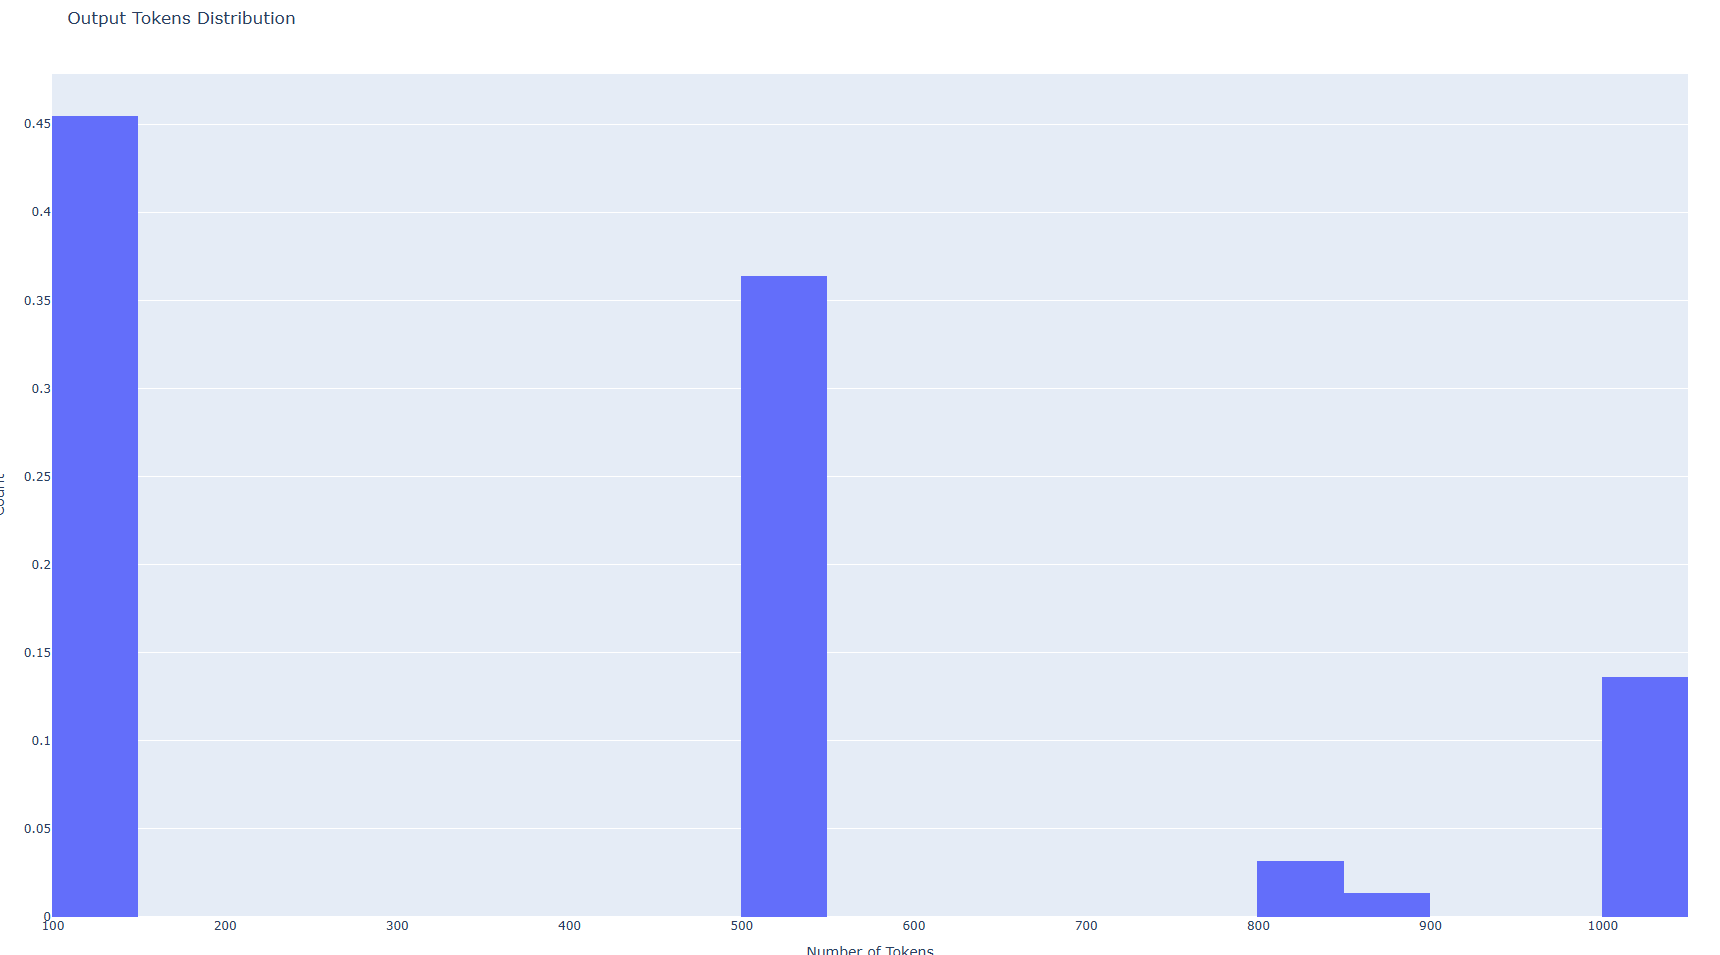

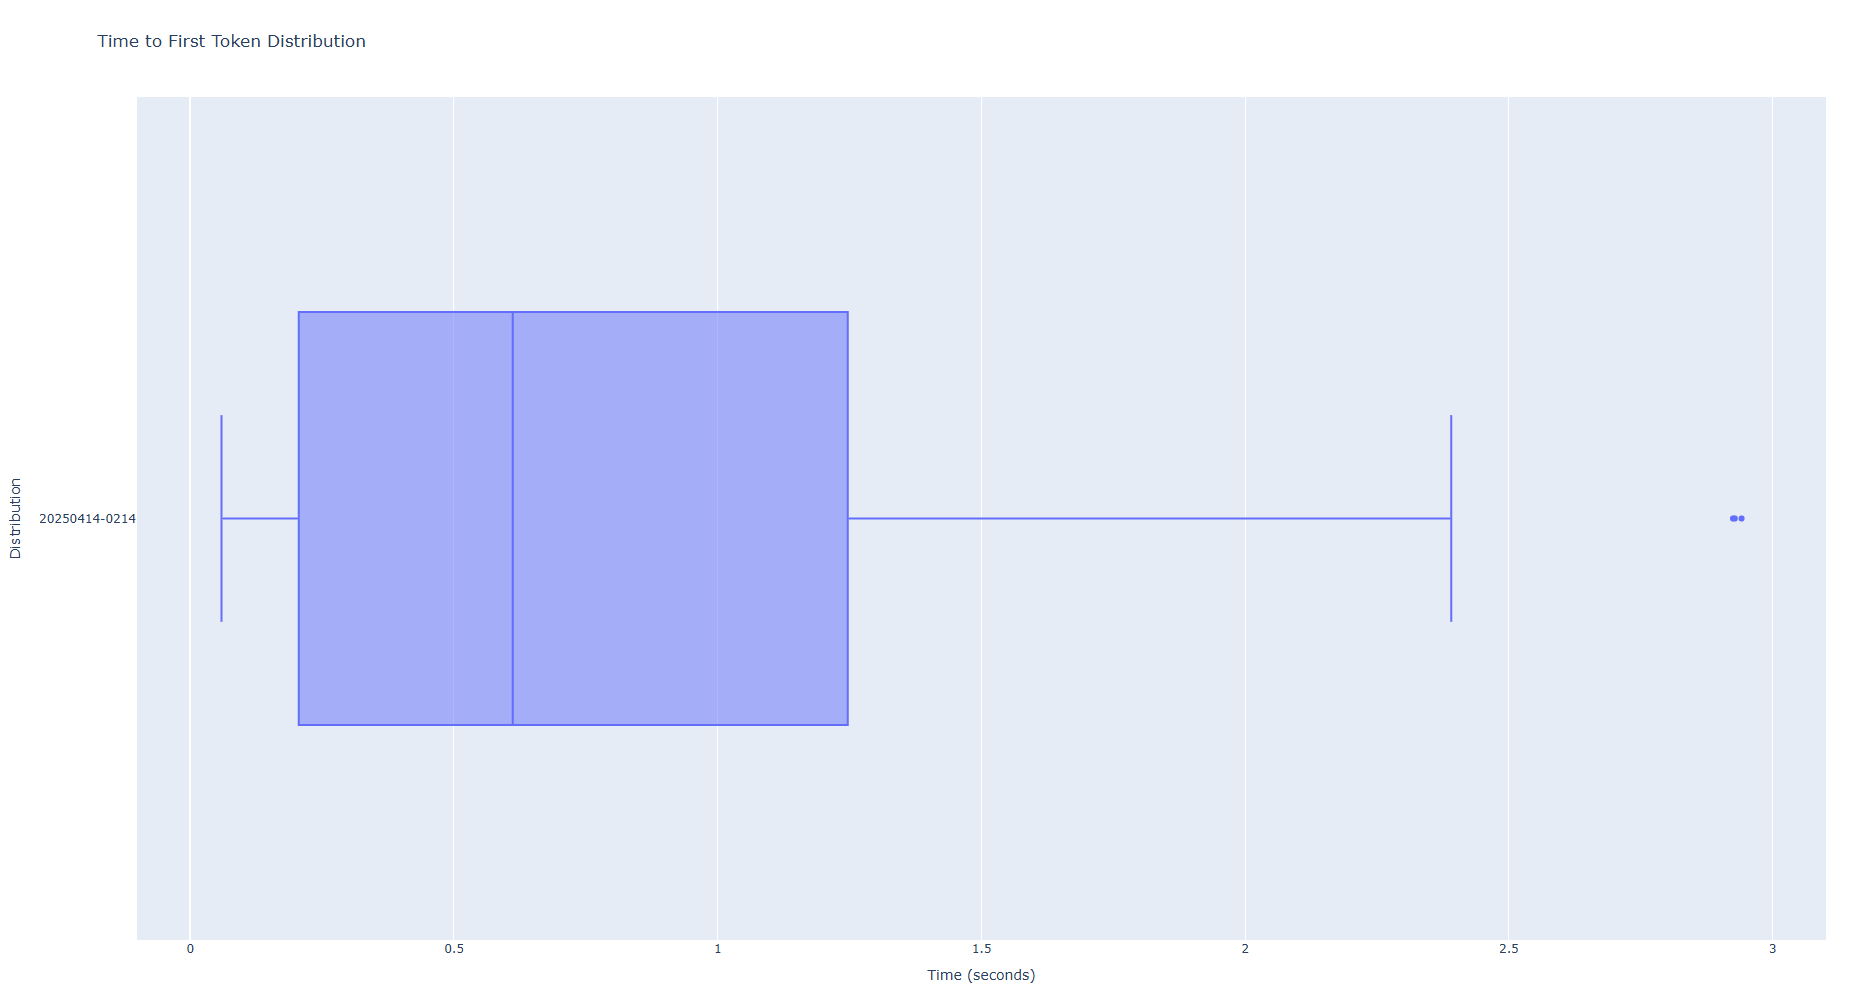

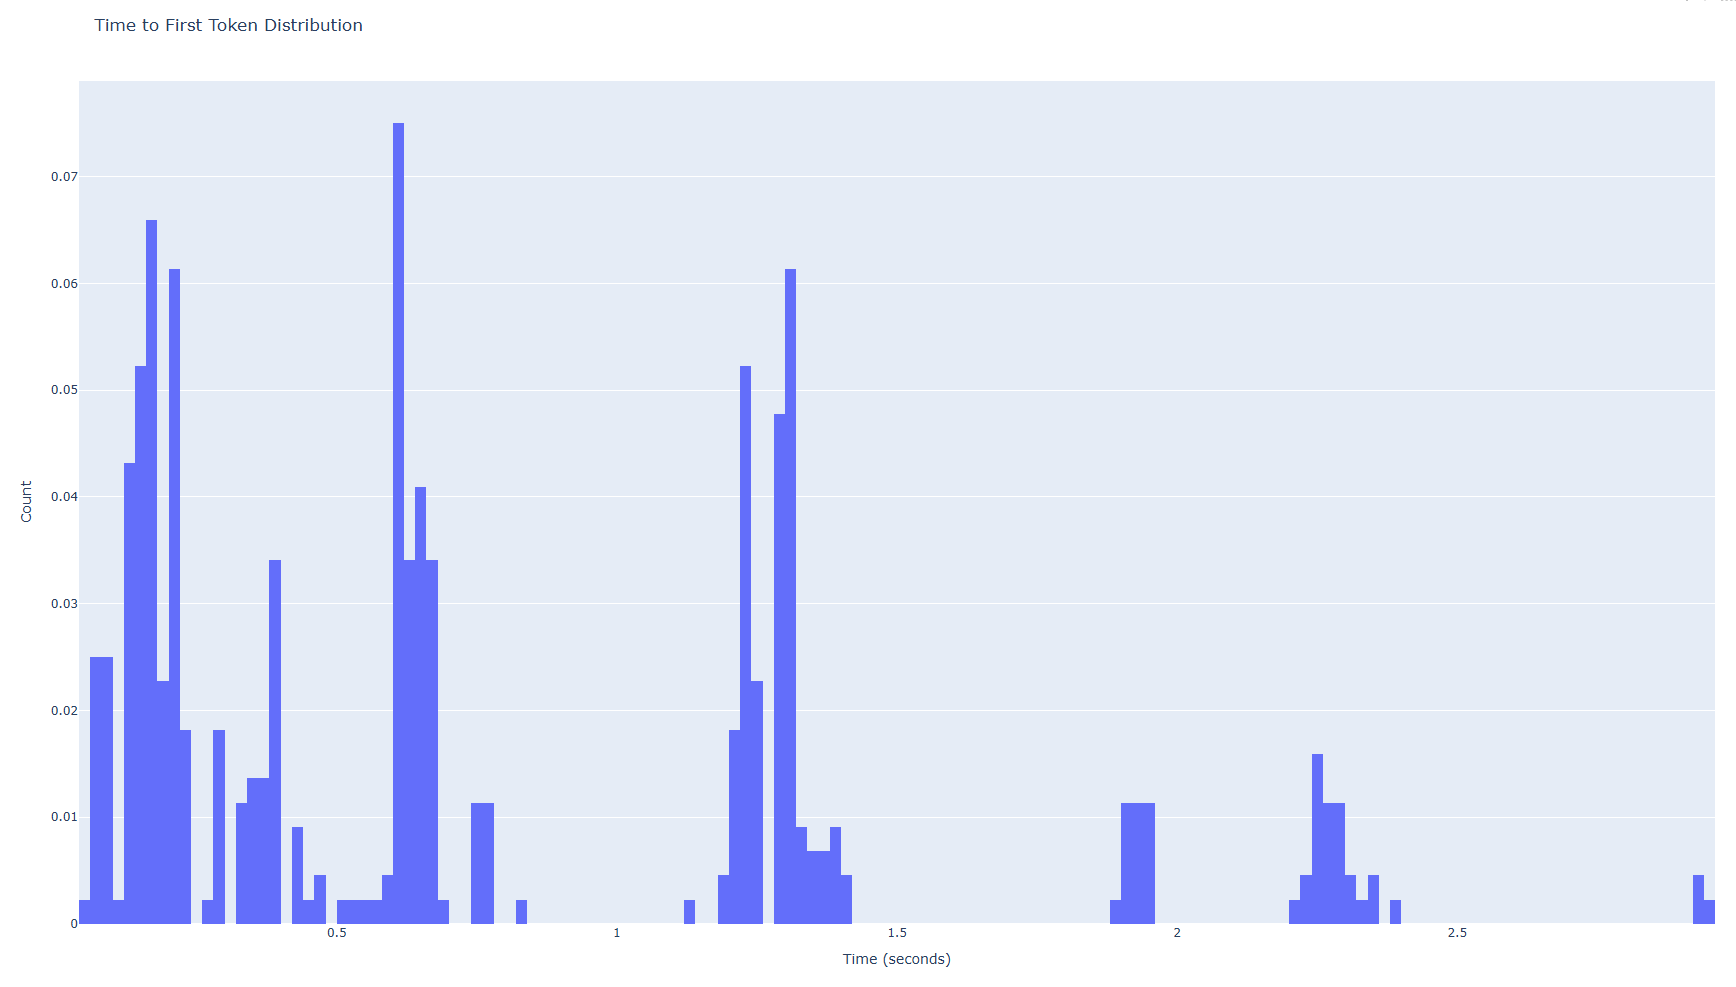

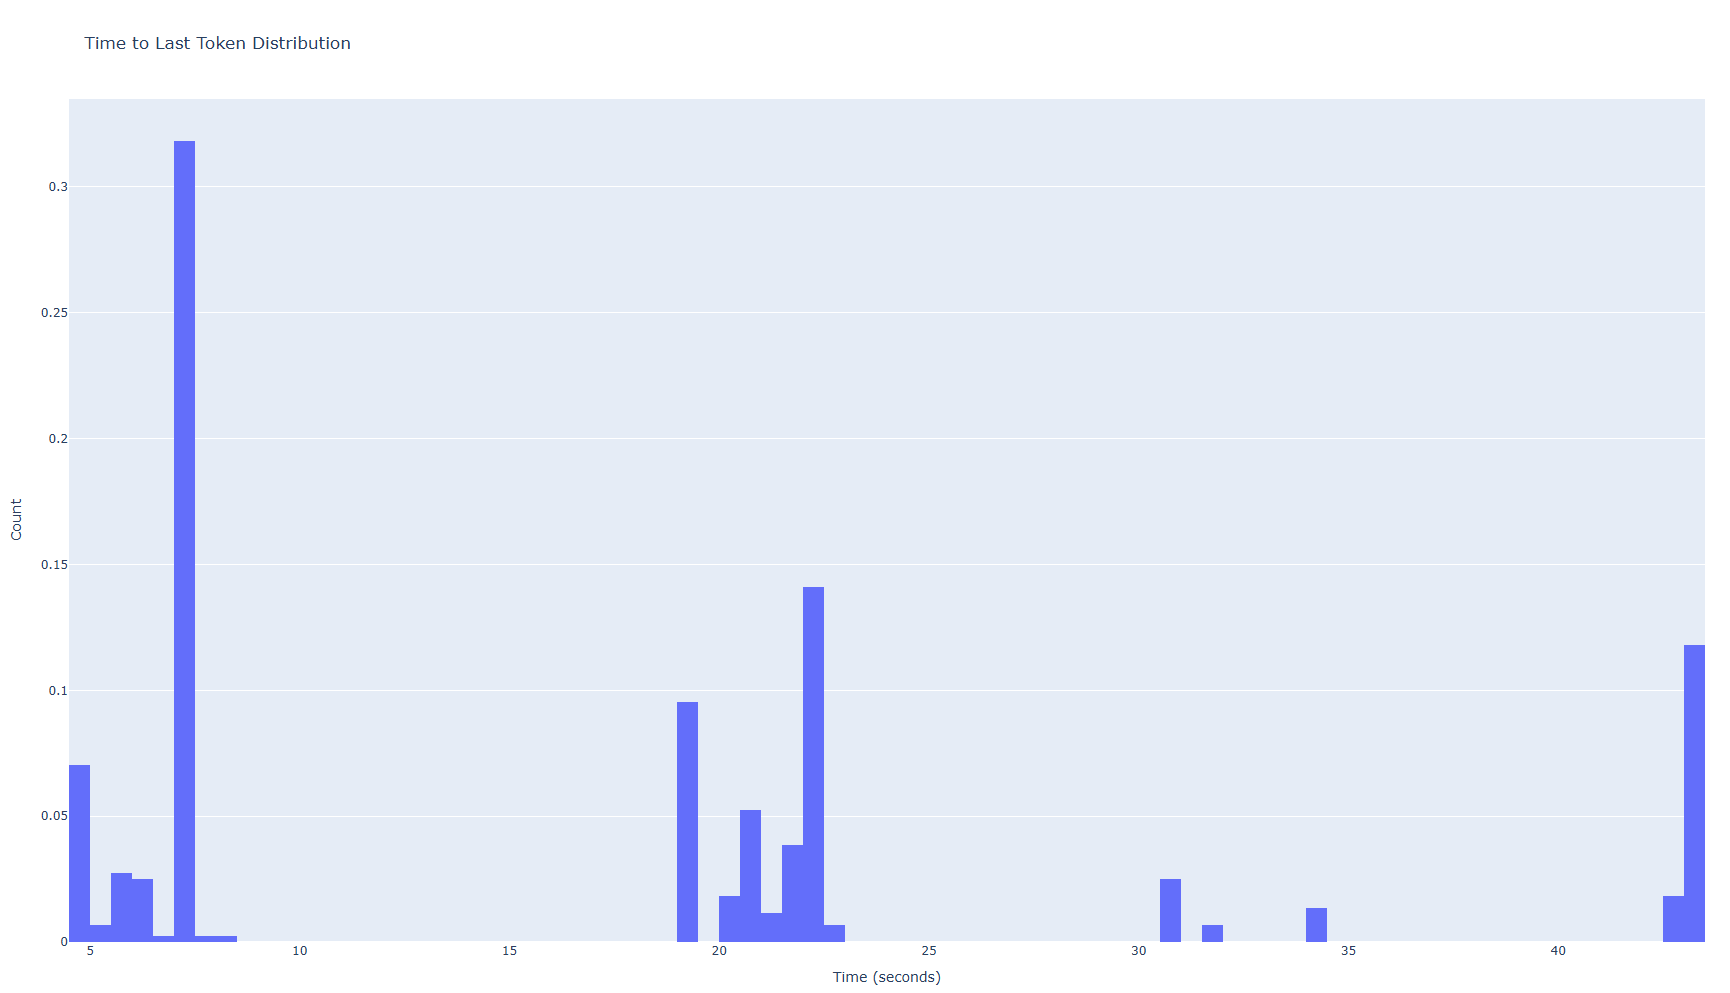



# Interpreting TTFT and TTLT Metrics from Load Testing

## Test Configuration
- Input: Passage from Frankenstein (literary text)
- Concurrent clients: 20
- Test type: Load test with varying input/output lengths

## Time to First Token (TTFT)
The TTFT histogram shows how quickly the model begins generating responses. Look for:
- Clustering of response times (main peak in distribution)
- Spread of the distribution (consistency)
- Presence of outliers (long tail)

**What this tells us**: TTFT indicates initial model responsiveness. Lower values suggest better user experience, while consistent values (narrow distribution) indicate reliable performance.

## Time to Last Token (TTLT)
The TTLT histogram shows total response generation time. Look for:
- Overall response time patterns
- Width of distribution (variation in completion times)
- Any significant outliers

**What this tells us**: TTLT reflects complete response generation time, influenced by:
- Text complexity
- Response length
- System load (20 concurrent clients)
- Model processing capabilities

Your actual numbers will vary based on model, infrastructure, and test conditions, but the patterns in these distributions help evaluate model performance characteristics.

## Clean up

Since SageMaker endpoints are [priced](https://aws.amazon.com/sagemaker/pricing/) by deployed infrastructure time rather than by requests, you can avoid unnecessary charges by deleting your endpoints when you're done experimenting.

You can un-comment and run the cell below to delete the `endpoint_name` used in this notebook, and also review any endpoints you might have running in the [Inference > Endpoints section of the SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/endpoints)

In [ ]:
# from sagemaker.predictor import Predictor
# Predictor(endpoint_name).delete_endpoint()